In [ ]:
# Optimal Threshold와 Holding Period를 Online으로 학습할 순 없을까?

In [3]:
import pandas as pd
import numpy as np
from utilities import *
from CrossValidation import *
from features import *
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [7]:
# Data
df_vol = pd.read_csv('data/NQ/NQ_dollar_w200_b300.csv', index_col=0)
# df_vol = pd.read_csv('data/NQ/NQ_dollar.csv', index_col=0)
df_vol.Time0 = pd.to_datetime(df_vol.Time0)#, unit='ms')
df_vol.Time1 = pd.to_datetime(df_vol.Time1)#, unit='ms')
df_vol.set_index('Time0', inplace=True)
df_vol['barID'] = df_vol.reset_index().index.values
df_vol = correct_duplicate_timeindex(df_vol)

/Users/kennypark/Desktop/nonsibi_capital/Analysis/utilities.py:535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ohlcv['Time0'].iloc[idx+i]+= pd.Timedelta(microseconds=(i))
/Users/kennypark/Desktop/nonsibi_capital/Analysis/utilities.py:535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ohlcv['Time0'].iloc[idx+i]+= pd.Timedelta(microseconds=(i))
/Users/kennypark/Desktop/nonsibi_capital/Analysis/utilities.py:535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [22]:
# Threshold Analysis without TP
df = df_vol
side = 'long'
sampling_lookback = 150 # 최소단위
holding_period_scales = [1, 2, 3, 6, 10]
side= 'long'
leverage = 3
commission = 0.0001 # Unlevered

# trainStart, trainEnd = pd.to_datetime("2000-01-01"), pd.to_datetime("2018-12-30"); trainDays = (trainEnd - trainStart).days/365*250
# testStart, testEnd = pd.to_datetime("2019-01-01"), pd.to_datetime("2024-03-01"); testDays = (testEnd - testStart).days/365*250
trainStart, trainEnd = pd.to_datetime("2010-01-01"), pd.to_datetime("2019-12-30"); trainDays = (trainEnd - trainStart).days/365*250
testStart, testEnd = pd.to_datetime("2020-01-01"), pd.to_datetime("2024-03-01"); testDays = (testEnd - testStart).days/365*250

feat = getBollinger(df.Close, sampling_lookback)
quantiles = feat.mean() + feat.std() * np.linspace(-3, -1, 30)
heatmap_u = pd.DataFrame(index = quantiles, columns = holding_period_scales, dtype=float)
heatmap_s = pd.DataFrame(index = quantiles, columns = holding_period_scales, dtype=float)
heatmap_r = pd.DataFrame(index = quantiles, columns = holding_period_scales, dtype=float)

for hpscale in holding_period_scales:
    hpbar = int(sampling_lookback*hpscale)
    utilities, sharpes, tot_rets, zscores,sharpe_freqs = getFeatUtility(feat[trainStart:trainEnd], side, quantiles, df, trainDays, 'outward', leverage, commission, hpbar, mid=0, visual=False)
    heatmap_u.loc[:,hpscale] = utilities
    heatmap_s.loc[:,hpscale] = sharpes
    heatmap_r.loc[:,hpscale] = tot_rets

# sns.heatmap(heatmap,  cmap='coolwarm', fmt='g', center=0);plt.show()


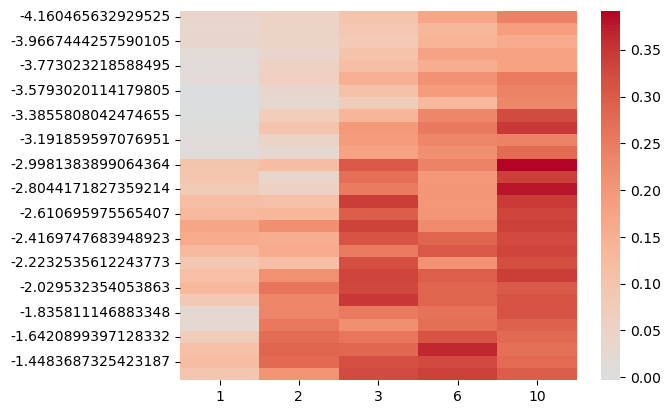

In [23]:
sns.heatmap(heatmap_r,  cmap='coolwarm', fmt='g', center=0);plt.show()

1 100


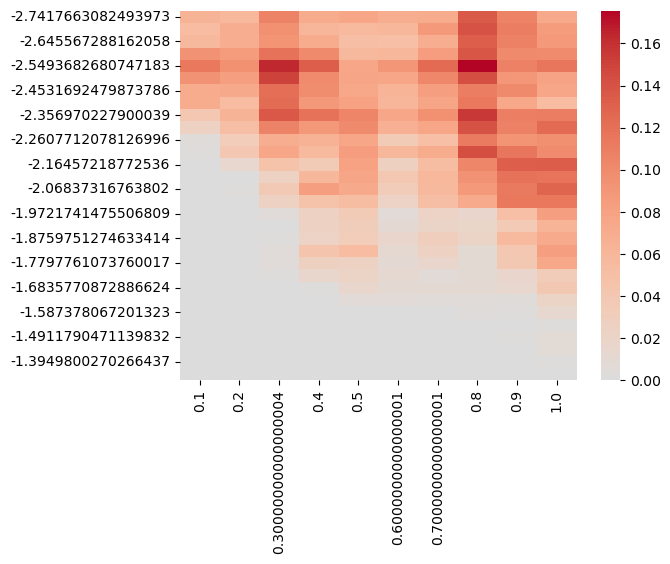

------------------------
2 200


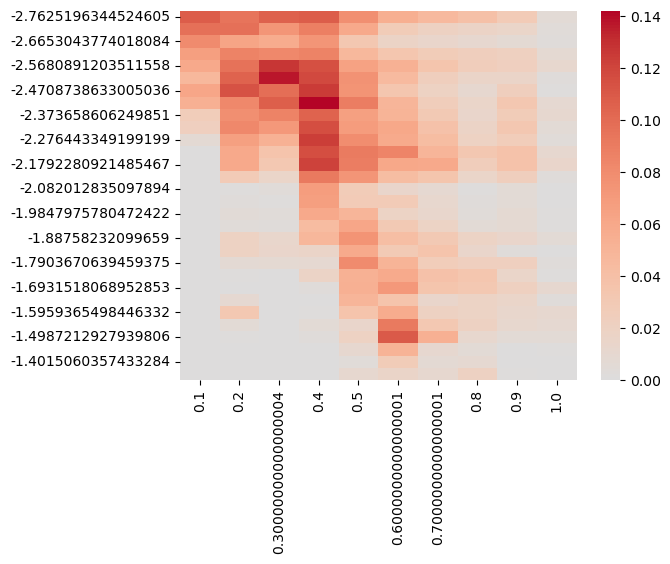

------------------------


In [14]:
# Threshold Analysis with TP
df = df_vol
side = 'long'
lookback = 100 # 최소단위
scales = [1, 2]
tp = 2
hp_asPctof_lookback = np.arange(0.1, 1.1,0.1)
side= 'long'
leverage = 3
commission = 0.0001 # Unlevered

trainStart, trainEnd = pd.to_datetime("2000-01-01"), pd.to_datetime("2018-12-30"); trainDays = (trainEnd - trainStart).days/365*250
testStart, testEnd = pd.to_datetime("2019-01-01"), pd.to_datetime("2024-03-01"); testDays = (testEnd - testStart).days/365*250


for scale in scales:
    feat = getBollinger(df.Close, lookback*scale)
    vol = np.log(df.Close).rolling(lookback*scale).std()
    quantiles = feat.mean() + feat.std() * np.linspace(-2, -1, 30)
    heatmap = pd.DataFrame(index = quantiles, columns = hp_asPctof_lookback, dtype=float)

    for hp_lb in hp_asPctof_lookback:
        hpbar = int(scale*lookback*hp_lb)
        # utilities, sharpes, tot_rets, zscores,sharpe_freqs = getFeatUtility(feat[trainStart:trainEnd], side, quantiles, df, trainDays, 'outward', leverage, commission, hpbar, mid=0, visual=False)
        utilities, sharpes, tot_rets, zscores, sharpe_freqs = getFeatUtility_tb(feat[trainStart:trainEnd], side, quantiles, df, trainDays, 'outward',vol, leverage, commission, tp = tp, hpBar = hpbar, mid=0, visual=False)
        heatmap.loc[:,hp_lb] = utilities

    print(scale, lookback*scale)
    sns.heatmap(heatmap,  cmap='coolwarm', fmt='g', center=0,);plt.show()
    print("------------------------")

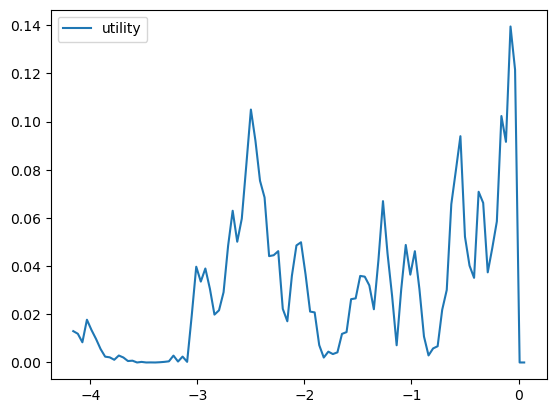

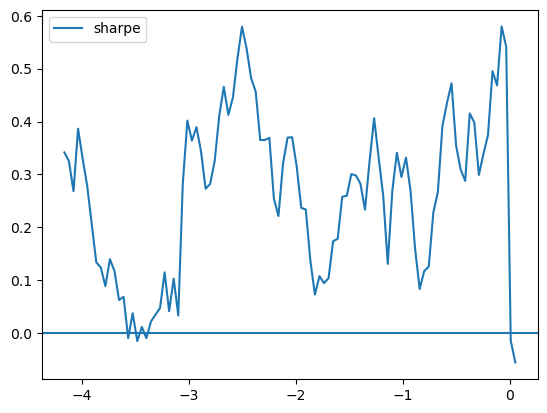

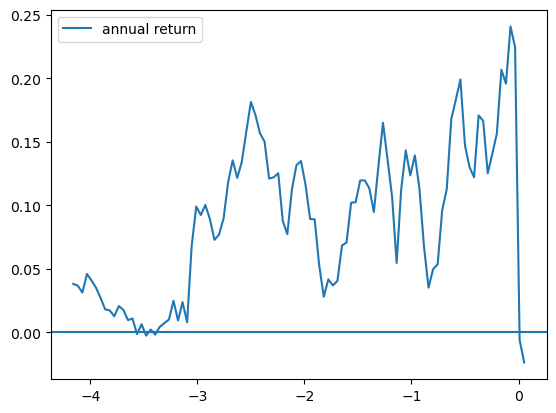

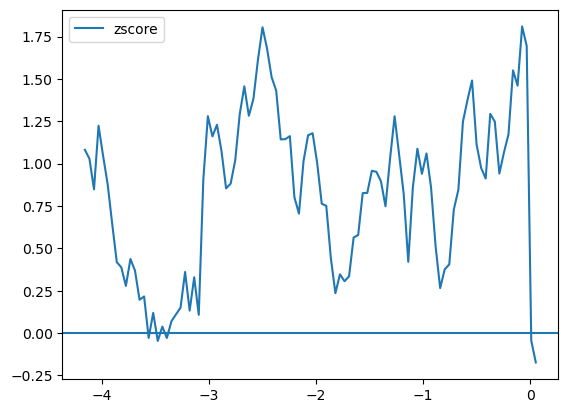

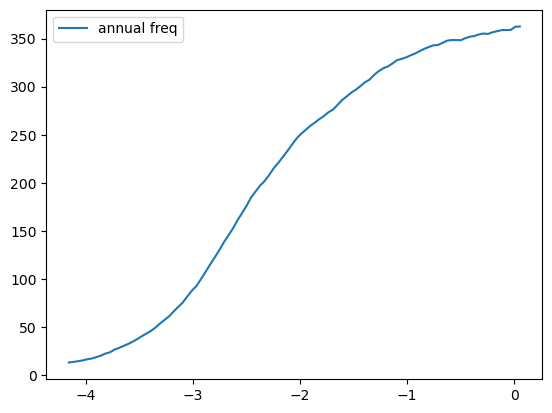

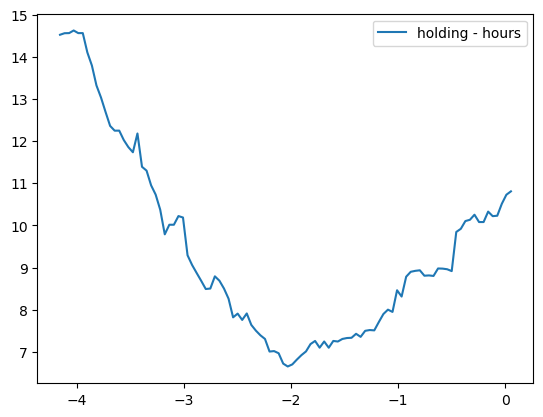

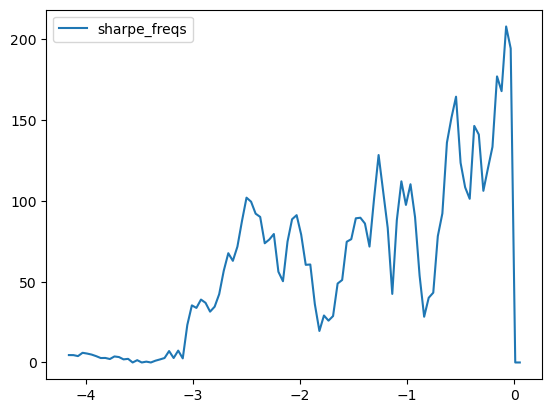

In [25]:
hpbar = 150
lookback = 150
side='long'
leverage = 3 
commission = 0.0001
df = df_vol
feat = getBollinger(df.Close, lookback)
quantiles = feat.mean() + feat.std() * np.linspace(-3, 0, 100)
utilities, sharpes, tot_rets, zscores, sharpe_freqs = getFeatUtility(feat[trainStart:trainEnd], side, quantiles, df, trainDays, 'outward', leverage, commission, hpbar, mid=0, visual=True)

# tp = 2
# vol = np.log(df.Close).rolling(lookback).std()
# utilities, sharpes, tot_rets, zscores, sharpe_freqs = getFeatUtility_tb(feat[trainStart:trainEnd], side, quantiles, df, trainDays, 'outward',vol, leverage, commission, tp, hpBar = hpbar, mid=0, visual=True)



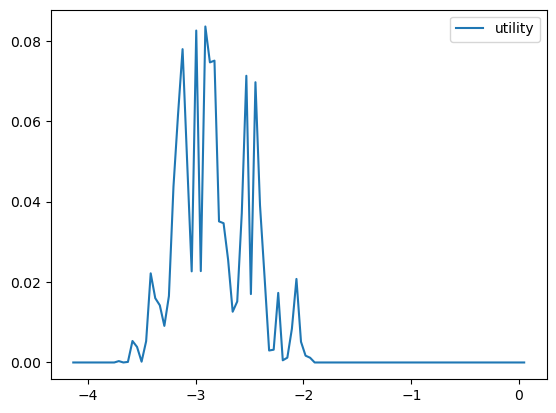

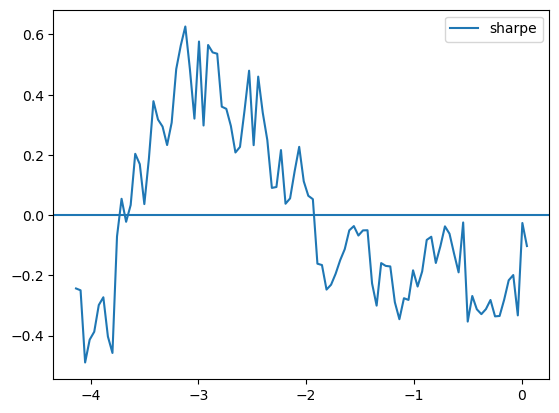

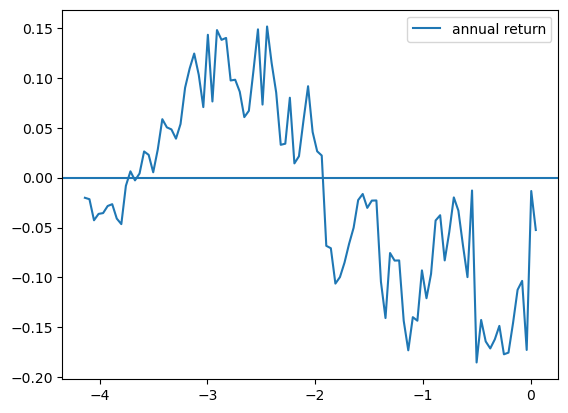

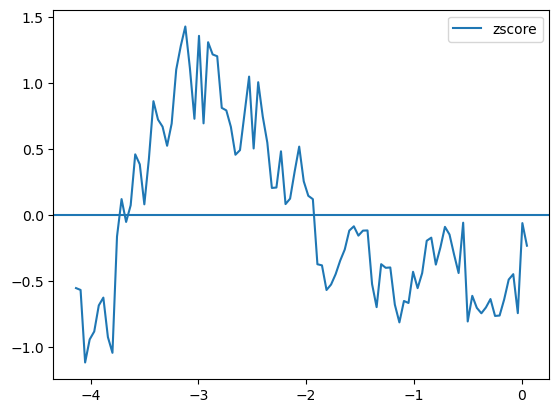

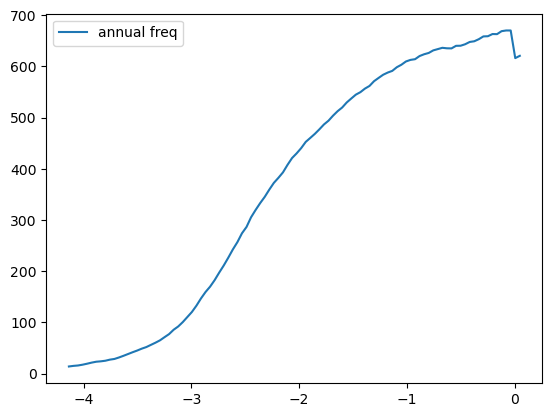

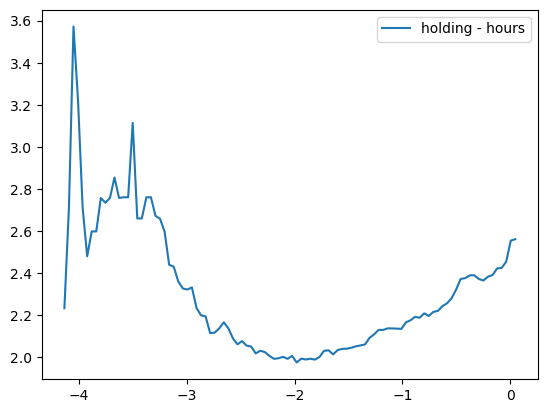

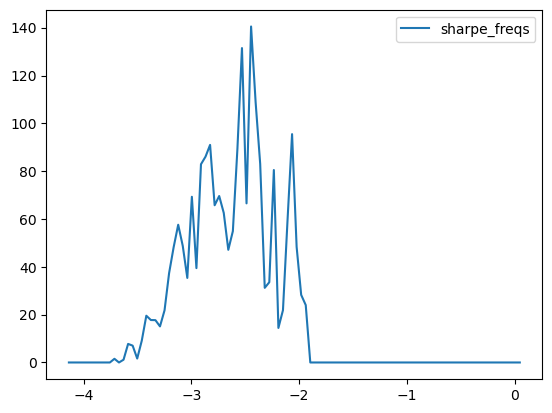

In [19]:
# Test
# utilities, sharpes, tot_rets, zscores, sharpe_freqs = getFeatUtility(feat[testStart:testEnd], side, quantiles, df, testDays, 'outward', leverage, commission, hpbar, mid=0, visual=True)
utilities, sharpes, tot_rets, zscores, sharpe_freqs = getFeatUtility_tb(feat[testStart:testEnd], side, quantiles, df, testDays, 'outward',vol, leverage, commission, tp, hpBar = hpbar, mid=0, visual=True)
